In [1]:
import pandas as pd
import numpy as np
import main as sigmod
import similar_feature_grouping as similar_feature_grouping
import helper as helper

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gunesyurdakul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset_path="../datasets/2013_camera_specs/"

In [3]:
dataset_df = sigmod.create_brand_dataframe(dataset_path)
dataset_df = sigmod.compute_brand_blocking(dataset_df)
#pairs_df = sigmod.get_block_pairs_df(dataset_df)

  0%|          | 0/24 [00:00<?, ?it/s]

>>> Creating dataframe...



100%|██████████| 24/24 [00:02<00:00,  9.42it/s]
308it [00:00, 3074.89it/s]

>>> Dataframe created successfully!

>>> Computing blocking...


29787it [00:06, 4668.98it/s]
29787it [00:05, 5828.93it/s]

ended
>>> Blocking computed successfully!



### GROUPING SAME PRODUCTS FROM LABELLED SET

In [4]:
labelled_df = pd.read_csv('../datasets/sigmod_large_labelled_dataset.csv')

In [5]:
same_products = sigmod.grouping_same_products_from_labelled_set(labelled_df)

In [6]:
#They all represent the same products
same_products[4]

['www.shopmania.in//932',
 'www.flipkart.com//2178',
 'www.pricedekho.com//1093',
 'www.mypriceindia.com//142',
 'www.gosale.com//1484',
 'www.ebay.com//56380',
 'www.ebay.com//24741']

### GET ALL KEYS and values

In [12]:
data_dict=sigmod.get_all_keys_values(dataset_path)
dataset_df['all_features'] = dataset_df['spec_id'].apply(lambda x: data_dict[x])

100%|██████████| 24/24 [05:14<00:00, 10.73s/it]


In [11]:
dataset_df.to_pickle('dataset_df.pickle')

In [14]:
a = pd.read_pickle('dataset_df.pickle')

In [15]:
dataset_df

,source,spec_number,spec_id,page_title,brand,blocking_key
0,www.wexphotographic.com,154,www.wexphotographic.com//154,nikon coolpix aw120 digital camera - camouflag...,,[coolpix]
1,www.wexphotographic.com,553,www.wexphotographic.com//553,canon ixus 150 digital camera - red (9148b007a...,,[canon]
2,www.wexphotographic.com,601,www.wexphotographic.com//601,fuji finepix s1 digital camera (p10nc12730a) -...,,[fujifilm]
3,www.wexphotographic.com,197,www.wexphotographic.com//197,nikon coolpix s5300 digital camera - black (vn...,,[coolpix]
4,www.wexphotographic.com,178,www.wexphotographic.com//178,fuji finepix s8600 digital camera - red (p10nc...,,[fujifilm]
...,...,...,...,...,...,...
29782,www.canon-europe.com,23,www.canon-europe.com//23,canon powershot a560 - powershot and ixus digi...,,[powershot]
29783,www.canon-europe.com,74,www.canon-europe.com//74,canon ixus 210 - powershot and ixus digital co...,,[powershot]
29784,www.canon-europe.com,62,www.canon-europe.com//62,canon ixus 125 hs - powershot and ixus digital...,,[powershot]
29785,www.canon-europe.com,9,www.canon-europe.com//9,canon digital ixus 70 - powershot and ixus dig...,,[powershot]


In [16]:
all_text=similar_feature_grouping.prepare_text_for_word2vec(data_dict)

0.03357169234901131
0.06714338469802263
0.10071507704703395
0.13428676939604525
0.16785846174505656
0.2014301540940679
0.2350018464430792
0.2685735387920905
0.3021452311411018
0.3357169234901131
0.3692886158391244
0.4028603081881358
0.4364320005371471
0.4700036928861584
0.5035753852351698
0.537147077584181
0.5707187699331924
0.6042904622822036
0.637862154631215
0.6714338469802262
0.7050055393292376
0.7385772316782488
0.7721489240272602
0.8057206163762716
0.8392923087252828
0.8728640010742942
0.9064356934233054
0.9400073857723168
0.973579078121328


In [17]:
from gensim.models import Word2Vec

In [18]:
emb_dim=200
model = Word2Vec(all_text, size=emb_dim, window=5, min_count=1, workers=4)
model.train(all_text,total_examples=model.corpus_count,epochs=model.epochs)

KeyboardInterrupt: 

In [ ]:
model.most_similar('supply ability')

In [ ]:
model.save('word2vec_200_features')

### GROUPING FEATURES

In [19]:
all_features={}
for features in data_dict.values():
    for feature in features.keys():
        if feature not in all_features.keys():
            all_features[feature]=0            
        all_features[feature]+=1

In [20]:
all_features_filtered=[feature for feature,count in all_features.items() if count>200]

In [21]:
len(all_features_filtered)

364

### CLUSTERING

In [22]:
model= Word2Vec.load('word2vec_200_features')
words = all_features_filtered
wvs = model.wv[words]


In [23]:
wvs.shape

(364, 200)

### TSNE

In [24]:
# visualize embeddings
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=20)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

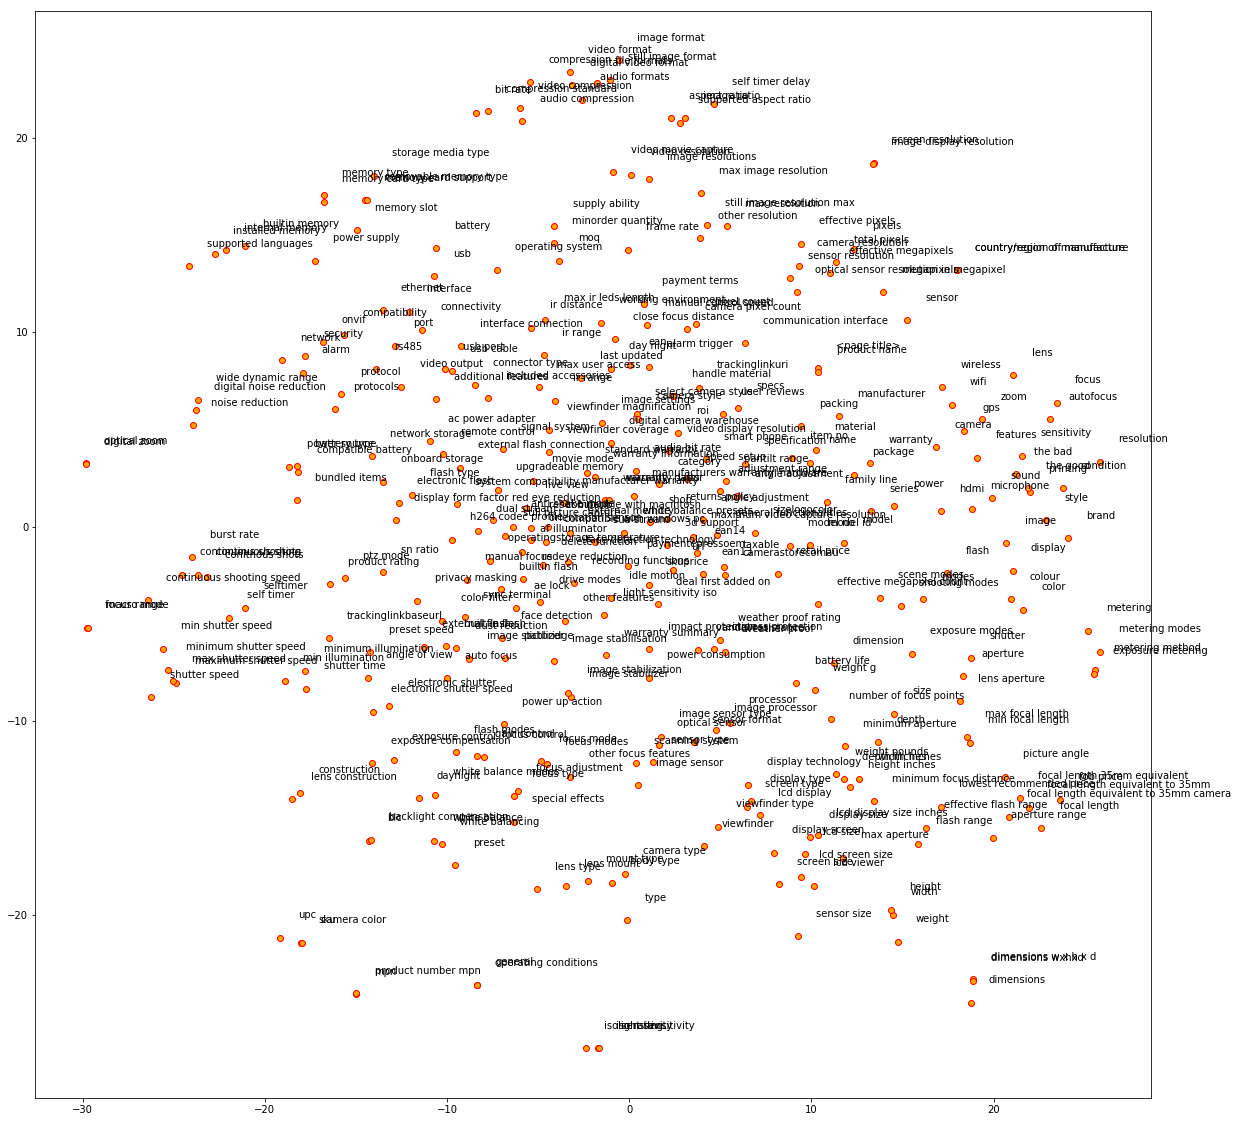

In [26]:
plt.show()

In [27]:
T.shape

(364, 2)

#### KMeans

In [28]:
from nltk.cluster import KMeansClusterer
import nltk
%matplotlib inline

In [29]:
NUM_CLUSTERS=50
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True,repeats=25)
assigned_clusters = kclusterer.cluster(T, assign_clusters=True)

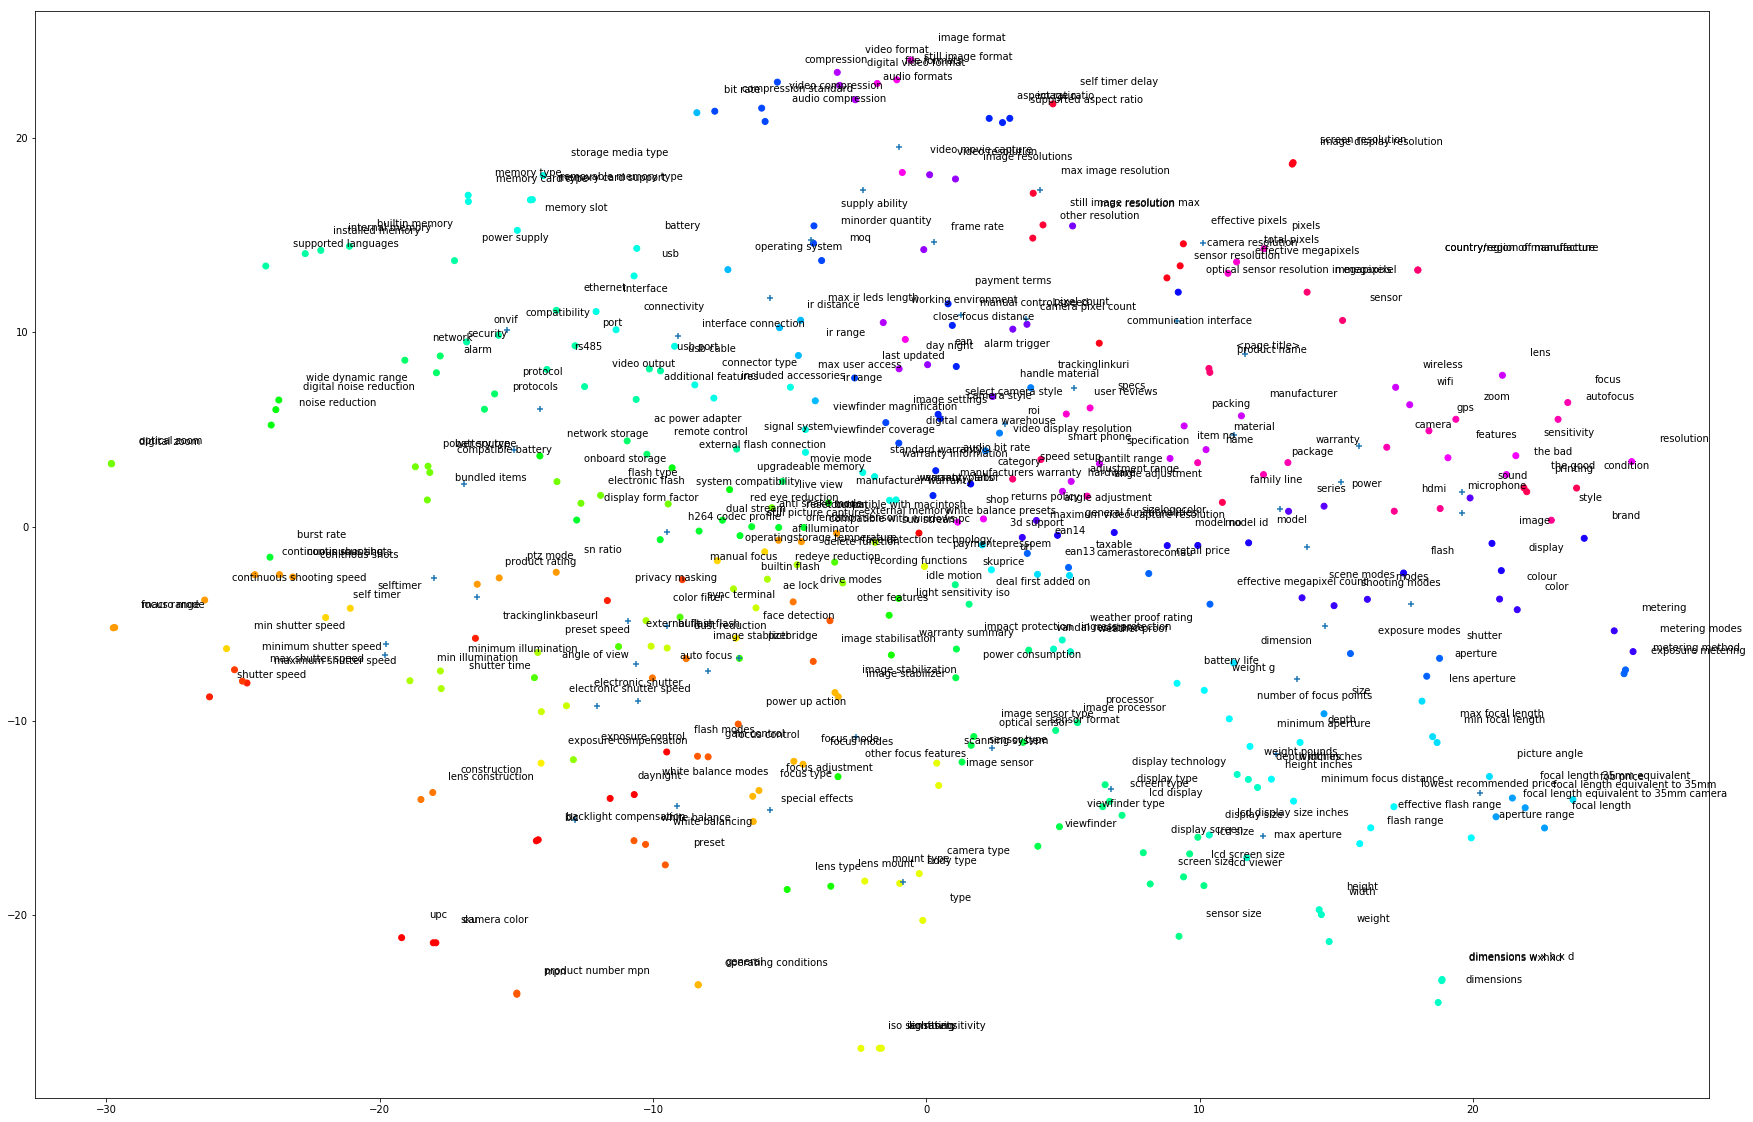

In [30]:
plt.figure(figsize=(30,20))
plt.scatter(T[:,0], T[:,1], c=assigned_clusters, cmap='hsv')
plt.scatter(np.array(kclusterer.means())[:,0], np.array(kclusterer.means())[:,1], marker='+', cmap='hsv')

for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [31]:
dataset_df,cluster2features = similar_feature_grouping.get_grouped_features(dataset_df,assigned_clusters,labels)

In [32]:
cluster2features

{0: ['blc',
  'upc',
  'white balance presets',
  'backlight compensation',
  'daynight',
  'sku',
  'flash modes',
  'camera color',
  'white balance modes'],
 1: ['shutter speed',
  'maximum shutter speed',
  'trackinglinkbaseurl',
  'privacy masking'],
 2: ['minimum shutter speed', 'manual focus', 'max shutter speed'],
 3: ['other features',
  'white balancing',
  'gain control',
  'white balance',
  'power up action',
  'mpn',
  'product number mpn',
  'preset',
  'focus control',
  'image stabilisation'],
 4: ['drive modes',
  'auto focus',
  'lens construction',
  'image stablizer',
  'construction'],
 5: ['conitnous shots',
  'continuous shots',
  'sn ratio',
  'external memory',
  'focus range',
  'product rating',
  'macro mode',
  'continuous shooting',
  'orientation sensor',
  'continuous shooting speed',
  'compatible with windows pc',
  'ptz mode'],
 6: ['focus modes',
  'focus adjustment',
  'operating conditions',
  'special effects',
  'general',
  'image stabilizer',


In [33]:
dataset_df = dataset_df.set_index('spec_id')

In [34]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
dataset_df.loc[same_products[1]]

,source,spec_number,page_title,brand,blocking_key,all_features,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
spec_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
www.ebay.com//54574,www.ebay.com,54574,nikon 1 j1 10 1 mp digital camera body only | ...,Nikon,[nikon],{'<page title>': 'nikon 1 j1 10 1 mp digital c...,,,,27526,,,,,,mirrorless interchangeable lens,,,,3x,,,,,,,,"3""",,,,,,,,,,,,,j1 nikon,,,,,,,,,,,,nikon 1 j1 10 1 mp digital camera body | ebay ...,,,
www.ebay.com//53623,www.ebay.com,53623,nikon 1 j1 10 1 mp digital camera white kit w ...,Nikon,[nikon],{'condition': 'used: item used previously. ite...,,,,27547,,,,,,mirrorless interchangeable lens,,,,"case bag, extra battery, lens cleaning kit, me...",,,,,,,,"3""",,,,,,,,,,,,,j1 nikon,,,,,,,,,,,,nikon 1 j1 10 1 mp digital camera white kit w ...,used: item used previously. item may signs cos...,,
www.buzzillions.com//1938,www.buzzillions.com,1938,nikon 1 j1 mirrorless digital camera two lens ...,,[nikon],"{'storage media type': 'secure digital (sd)', ...",red silver / gray white,,,,,,,,,,,,,,,,,,,,,3 inch,,,secure digital (sd),,,,,,,,mirrorless interchangeable lens cameras,,,,,10 megapixel,,,description included,,,,,,cmos nikon 1 j1 mirrorless digital camera two ...,,,
www.ebay.com//45409,www.ebay.com,45409,nikon 1 j1 10 1 mp digital camera white kit w ...,Nikon,[nikon],"{'condition': 'new (see details): new, unused ...",846431072519,,,27547,,,,,,mirrorless interchangeable lens,,,,,,,,,,,,"3""",,,,,,,,,,,,,j1 nikon,,,,,,,,,,,,nikon 1 j1 10 1 mp digital camera white kit w ...,"new (see details): new, unused item absolutely...",,
www.ebay.com//48083,www.ebay.com,48083,nikon 1 j1 10 1 mp digital camera white kit wi...,Nikon,[nikon],{'condition': 'used: item used previously. ite...,,,,27528b,,,,,,mirrorless interchangeable lens,,,,3x,,,,,,,,"3""",,,,,,,,,,,,,j1 nikon,,,,,,,,,,,,10.1 mp nikon 1 j1 10 1 mp digital camera whit...,used: item used previously. item may signs cos...,,
www.ebay.com//55629,www.ebay.com,55629,nikon 1 j1 10 1 mp digital camera white kit w ...,Nikon,[nikon],"{'mpn': '27528b', 'intuitive simplicity': 'eas...",,,,27528b,,,,,,mirrorless interchangeable lens,,,,3x,,,,,,,,"3""",,,,,,,,,,,,,j1 nikon,,,,,,,,,,,,nikon 1 j1 10 1 mp digital camera white kit w ...,,,
www.ebay.com//58668,www.ebay.com,58668,nikon 1 j1 10 1 mp digital camera white body o...,Nikon,[nikon],"{'upc': '018208922529', 'mpn': '34202', 'megap...",018208922529,,,34202,,,,,,mirrorless interchangeable lens,,,,,,,,,,,,"3""",,,,,,,,,,,,,j1 nikon,,,,,,,,,,,,10.1 mp nikon 1 j1 10 1 mp digital camera whit...,,,
www.ebay.com//56800,www.ebay.com,56800,sealed nikon 1 j1 digital camera bundle w 10 3...,Nikon,[nikon],{'condition': 'manufacturer refurbished: item ...,182008275281,,,27528b,,,,,,mirrorless interchangeable lens,,,,case bag 3x,,,,yes,,,,"3""",,,,,,,,,,,,,j1 nikon,,,,,,,,,,,,sealed nikon 1 j1 digital camera bundle w 10 3...,manufacturer refurbished: item professionally ...,,
www.ebay.com//59369,www.ebay.com,59369,nikon 1 j1 10 1 mp digital camera black kit w ...,Nikon,[nikon],"{'upc': '018208922864', 'condition': 'used: it...",018208922864,,,nikonj1blk103030110,,,,,,mirrorless interchangeable lens,,,,,,,,,,,,"3""",,,,,,,,,,,,,j1 nikon,,,,,,,,,,,,10.1 mp nikon 1 j1 10 1 mp digital camera blac...,used: item used previously. item may signs cos...,,


# FOR A SINGLE BLOCK - Nikon

In [35]:
dataset_df.head(50)
dataset_df = dataset_df.explode('blocking_key')
grouped_df = dataset_df.groupby(['blocking_key'])

In [36]:
[(key,value) for key,value in grouped_df.size().items() if value>1000]

[('coolpix', 1959),
 ('eos', 2437),
 ('fujifilm', 1498),
 ('hikvision', 1961),
 ('nikon', 2856),
 ('olympus', 1457),
 ('other', 4045),
 ('panasonic', 1321),
 ('powershot', 2268),
 ('samsung', 1081),
 ('sony', 2685)]

In [83]:
blocking_key="panasonic"
block_df = grouped_df.get_group(blocking_key)

In [84]:
len(set(dataset_df['blocking_key']))

96

In [85]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
block_df

,source,spec_number,page_title,brand,blocking_key,all_features,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
spec_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
buy.net//4310,buy.net,4310,panasonic i-pro smarthd wvst162 network camera...,,panasonic,"{'analog video out': 'yes', 'image sensor': 'm...",auto,,,,,,,,,mos surveillance/network camera,,,,8x,,,,,,,,,,12.17 oz 3.9 3.9,,2.9 http://www.panasonic.com,,,1.95 mm,,,,,,,800 x 600,,,,,,,,,,,panasonic i-pro smarthd wvst162 network camera...,,,
buy.net//5455,buy.net,5455,panasonic lumix dmc-xs1 16.1 megapixel compact...,,panasonic,"{'image sensor': 'ccd', 'lcd screen size': '2....",autodaylightcloudyshadeincandescentwhite set,,,,6 elements 5 groups,,optical,,,ccd compact camera iso 6400,,yes,program ae,5 x 4x,,yes,,,,,,2.7,,3.10 oz 3.7 2.1,1 year microsd card|microsdhc card|secure digi...,0.7 http://www.panasonic.com,,,4.30 mm 21.50 mm 24 mm 120 mm 24 mm 120 mm,,,,,,red-eye fix|red-eye reduction|auto flash|flash...,1280 x 720,,,,,,,,16600000 16.1 megapixel,,,panasonic lumix dmc-xs1 16.1 megapixel compact...,,,
buy.net//5475,buy.net,5475,panasonic lumix dmc-zs40 black digital camera ...,,panasonic,"{'image sensor': 'cmos', 'lcd screen size': '3...",,,,,,,optical,,,cmos point & shoot digital camera,,,,30 x 4 x,,,,,,,,3,12 mb,3.3 1/f 0.47 lbs 2.53 4.35,1 year(s) usb secure digital high capacity (sd...,1.35 http://shop.panasonic.com/shop/model/dmc-...,,,4.3 mm 129mm 24 mm 720mm,,,,,,built-in flash,1920 x 1080,,,,,yes,,,"18,900,000 pixels 18,100,000 pixels",,,panasonic lumix dmc-zs40 black digital camera ...,,,
buy.net//5645,buy.net,5645,panasonic lumix dmc-zs40 black digital camera ...,,panasonic,"{'image sensor': 'cmos', 'lcd screen size': '3...",,,,,,,,,,cmos point & shoot digital camera,,,,30 x 4 x,,,,,,,,3,12 mb,3.3 1/f 0.47 lbs 2.53 4.35,1 year(s) usb secure digital (sd) card|secure ...,1.35 http://shop.panasonic.com/shop/model/dmc-...,,,4.3 mm 129 mm 24 mm 720 mm,,,,,,built-in flash,1920 x 1080,,,,,yes,,,18900000 pixels 18100000 pixels,,,panasonic lumix dmc-zs40 black digital camera ...,,,
buy.net//5666,buy.net,5666,panasonic lumix dmc-lf1 white digital camera (...,,panasonic,"{'image sensor': 'mos', 'lcd screen size': '3'...",,,,,,,optical,,,mos bridge camera,,,,7.1 x 4x,,,,,,,,3,87 mb,2 1/f 6.00 oz 2.4 4.0,1 year usb secure digital (sd) card|secure dig...,1.1 http://www.panasonic.com,,,6 mm 42.80 mm 28 mm 200 mm,,,,,,auto flash|flash on|flash off|red-eye reductio...,1920 x 1080,,,,,yes,,,12800000 12.1 megapixel,,,panasonic lumix dmc-lf1 white digital camera (...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
www.wexphotographic.com//607,www.wexphotographic.com,607,panasonic lumix dmc-sz8 digital camera - black...,,panasonic,"{'max aperture tele': '6.3', 'movie mode': '72...",,,,yes,,,,,,,,,"1/3 ev step, +/-2 ev",built-in,yes,yes,,,,ccd lcd,720p,1/2.33 inch,,,"output (pal / ntsc), usb (av/usb multi)",144,,,99.8 x 60.4 x 26.5 mm,,30 scene modes,,,,,black,,,,,,4608 x 3456,"jpeg, quicktime motion jpeg",,,,panasonic lumix dmc-sz8 digital camera - black...,,,
www.wexphotographic.com//608,www.wexphotographic.com,608,panasonic lumix dmc-tz55 digital camera - blac...,,panasonic,"{'max aperture tele': '6.4', 'movie mode': '10...",,,,yes,,,,,,,,,"1/3 ev step, +/-2 ev",built-in,yes,yes,,,,mos lcd,1080p,1/2.33 inch,,,"microhdmi, output (pal / ntsc), usb (av/usb mu...",224 3cm,,,106.8 x 62.2 x 32.4 mm,,,,,,,black,,,,,,4608 x 3456,"jpeg, mp4",,,,panasonic lumix dmc-tz55 digital camera - blac...,,,
www.wexphotographic.com//614,www.wexphotographic.com,614,panasonic lumix dmc-lx100 digital camera - bla...,,panasonic,"{'max aperture tele': '2.8', 'movie mode': '4k...",,,,yes,,,,,,,,,+/- 3.0ev 1/3 step,built-in

## CLUSTERING INSIDE BLOCK

In [86]:
#concatanate new features
block_df['concat_text']=''
for i in range(NUM_CLUSTERS):
    block_df['concat_text']+=block_df[i]+' '
block_df['concat_text'] = block_df['concat_text'].apply(lambda x: x.replace('  ',' '))

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [87]:
def get_avg_vector(x,brand):
    avg=np.zeros((200,))
    x=x.replace(brand,'')
    x=x.replace('  ',' ')
    words = x.split() 
    model_vec=model.wv[brand]
    if len(words)>1 and words[0] in model.wv: 
        model_vec= model.wv[words[0]] 
    for i in range(len(words[1:])):
        word=words[i]
        if word in model.wv:
            avg += model.wv[word]  
    if len(words)>0:
        avg= avg/(len(words))
    return np.concatenate((model_vec,avg))

In [88]:
import re
from nltk import everygrams

block_df['concat_wordvector']=''
for index, row in block_df.iterrows():
    x=row['page_title']
    block_df.at[index,'concat_wordvector']=get_avg_vector(\
        ' '.join([' '.join(x[idx:].split()[:3]) for idx in [x.start() for x in re.finditer(blocking_key, x)]] + [' '.join(sigmod.extract_model_words(token)) for token in list(everygrams(x.split(),2,3))]),blocking_key)                                                                                                                                                     

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [89]:
X=np.zeros((len(block_df),400))
for i in range(len(block_df)):
    X[i]=block_df['concat_wordvector'][i]

In [90]:
# visualize embeddings
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=20)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(X)
labels = block_df['spec_number'].values

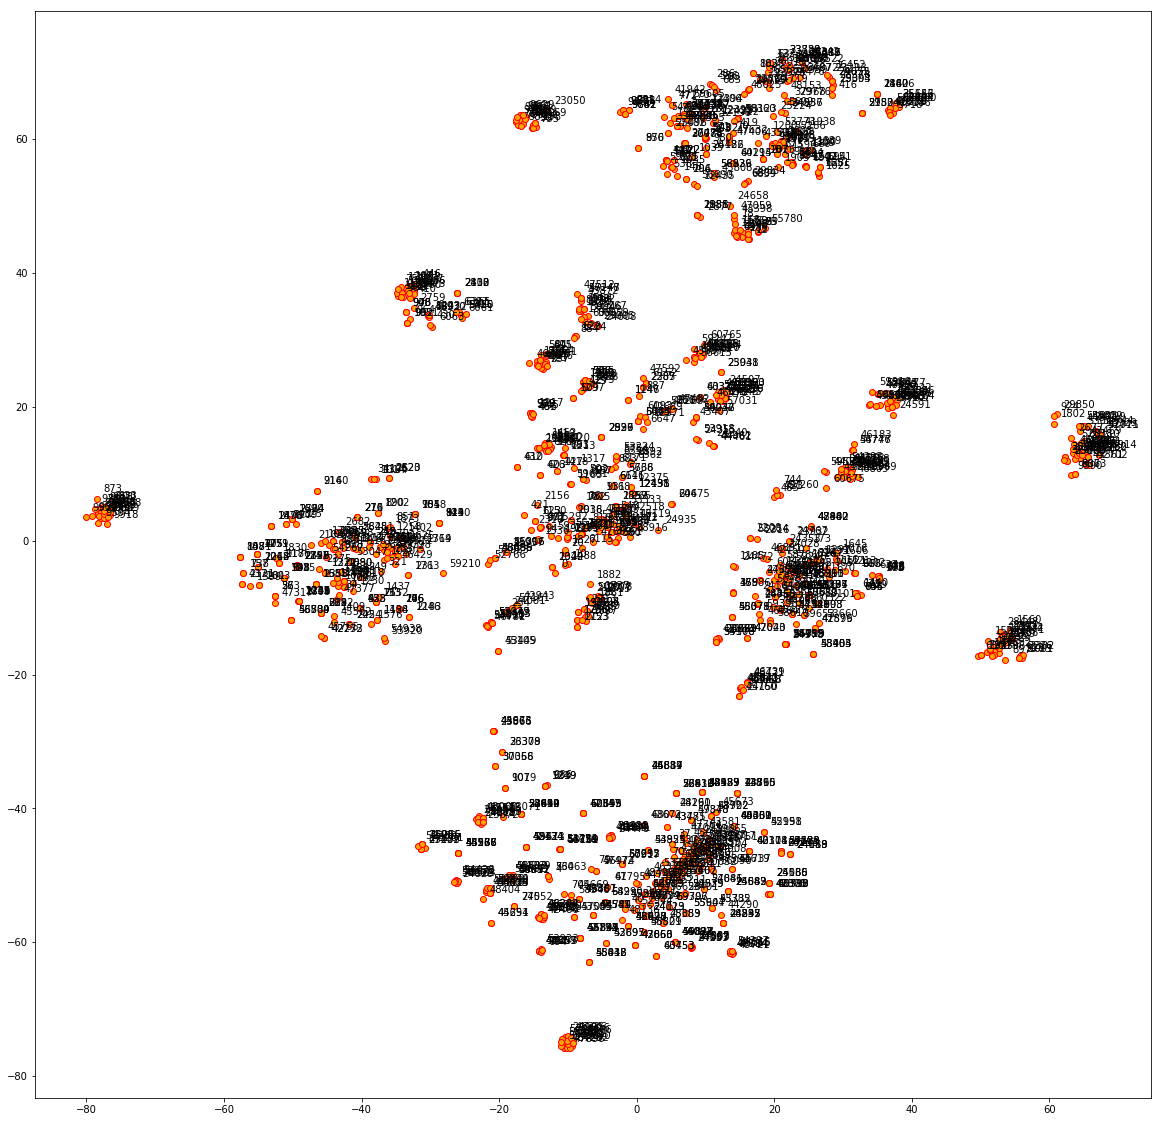

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [92]:
plt.show()

In [93]:
T.shape

(1321, 2)

#### KMeans

In [94]:
from nltk.cluster import KMeansClusterer
import nltk
%matplotlib inline

In [95]:
from sklearn.cluster import KMeans
import numpy as np
kclusterer = KMeans(n_clusters=5, random_state=0).fit(T)
assigned_clusters = kclusterer.labels_

In [111]:
from sklearn.cluster import DBSCAN
import numpy as np
kclusterer = DBSCAN(eps=0.5, min_samples=1).fit(T)
assigned_clusters = kclusterer.labels_

In [112]:
len(set(assigned_clusters))

675

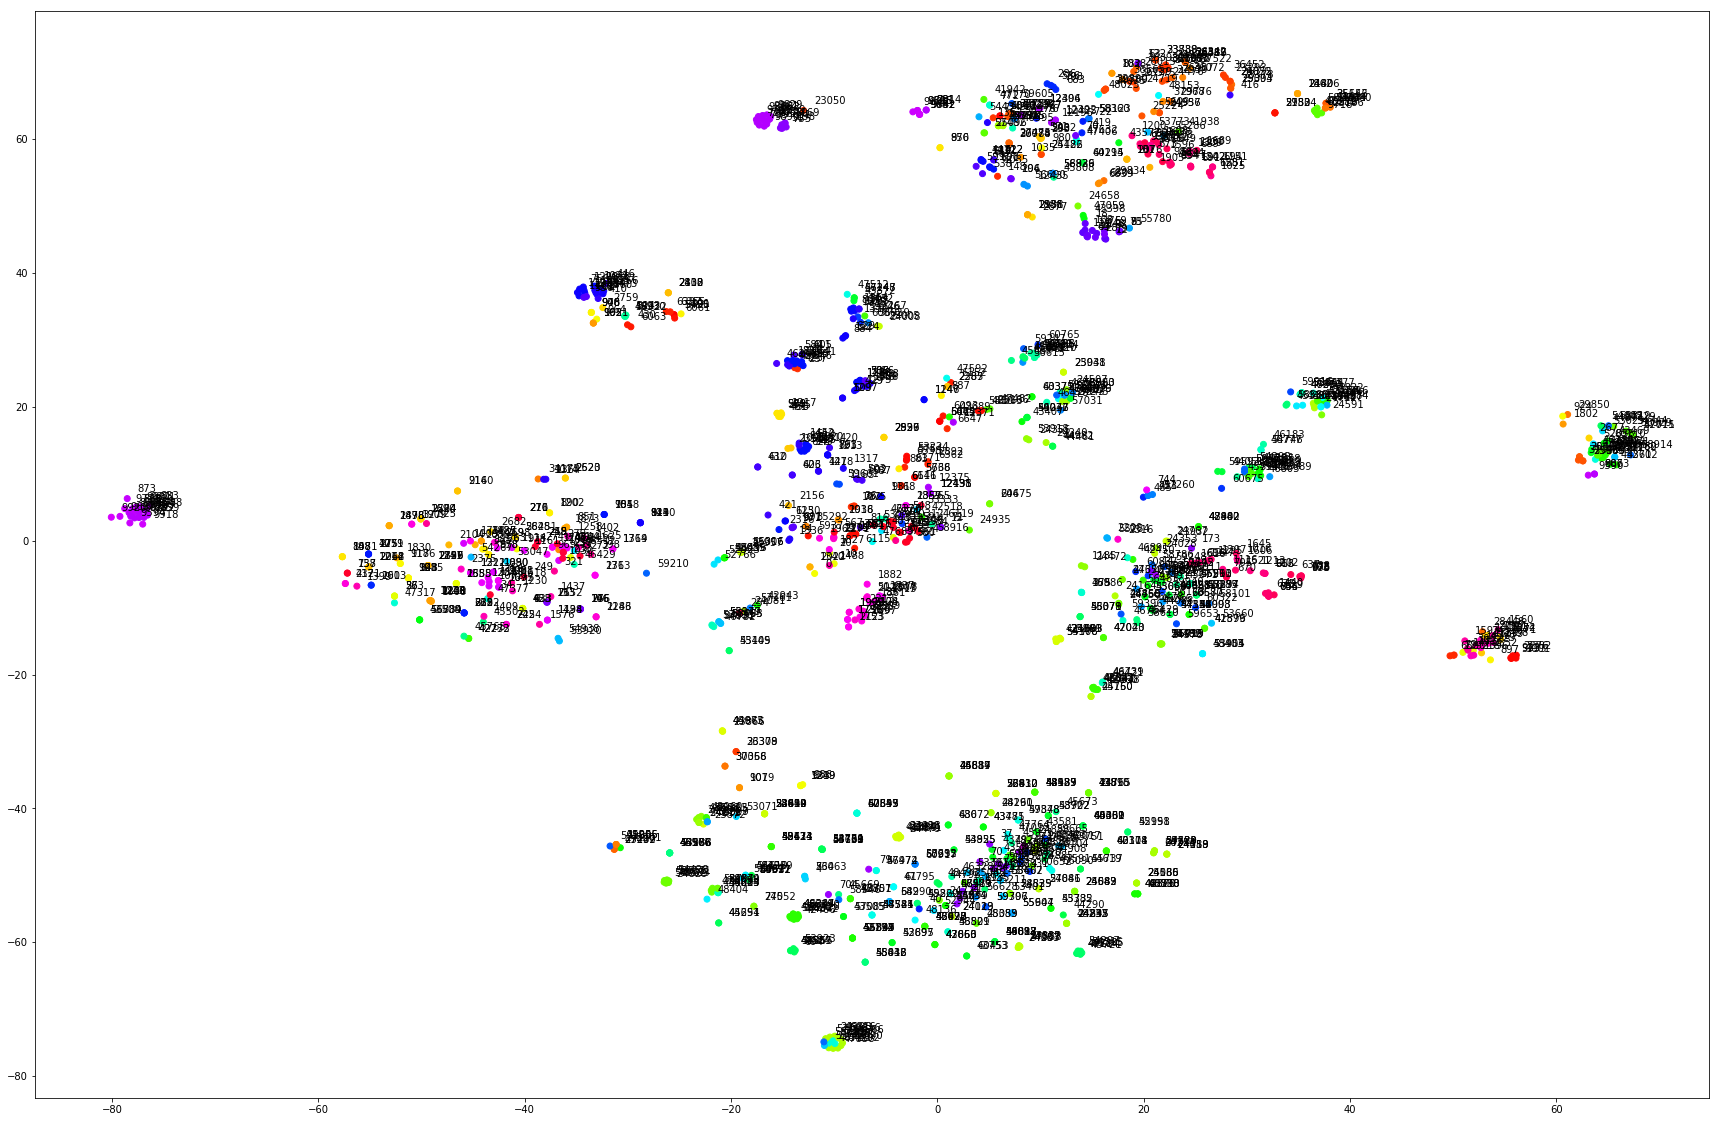

In [113]:
plt.figure(figsize=(30,20))
plt.scatter(T[:,0], T[:,1], c=assigned_clusters, cmap='hsv')

for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [114]:
block_df['inblock_cluster'] = assigned_clusters

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [115]:
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 3000
block_group_df = block_df.groupby('inblock_cluster')

In [117]:
for i in range(len(list(set(assigned_clusters)))):
    if(len(block_group_df.get_group(i)[['page_title']])==1):
        print(block_group_df.get_group(i)[['page_title']].values)
        print('-------------------')
        

[['panasonic lumix dmc-g5 black digital camera body only (16.05 mp, sd/sdhc/sdxc card slot) price comparison at buy.net']]
-------------------
[['panasonic lumix dmc-fx48 12.1 megapixel compact camera - black (2.5" lcd - 5x optical zoom - 4000 x 3000 image - 848 x 480 video - pictbridge) price comparison at buy.net']]
-------------------
[['panasonic lumix dmc-fz30 8 megapixel bridge camera - black (2" lcd - 12x optical zoom - secure digital sd card included - 3264 x 2448 image - 640 x 480 video - pictbridge) price comparison at buy.net']]
-------------------
[['panasonic lumix g series dmc-g6kk black slr digital camera kit w/ 14-42 mm ii lens (16.05 mp, sd/sdxc/sdhc card slot) price comparison at buy.net']]
-------------------
[['panasonic lumix dmc-fh10 black digital camera (16.1 megapixel - 2.7" lcd - 5x optical zoom - optical is - 4608 x 3456 image - 1280 x 720 video - pictbridge - hd movie mode) price comparison at buy.net']]
-------------------
[['panasonic lumix dmc-lx7 black di

-------------------
[['panasonic lumix dmc fz1000 digital camera 4k qfhd 20m 1" mos 25 400mm japan new | ebay']]
-------------------
[['panasonic lumix dmc tz tz 60 18 1 mp digital camera black japan free shipping | ebay']]
-------------------
[['panasonic dmc gx1 16 mp micro body 14 42mm f3 5 5 6 ois g vario len openbox | ebay']]
-------------------
[['panasonic lumix dmc zs25 dmc tz35 16 1 mp 20x optical zoom digital camera 689466657111 | ebay']]
-------------------
[['panasonic lumix dmc tz5e a 9 1 mp digital camera blue | ebay']]
-------------------
[['panasonic lumix dmc ts1 dmc ft1 12 1 mp digital camera silver | ebay']]
-------------------
[['panasonic lumix dmc ts3 waterproof shockproof digital camera plus extras 885170031562 | ebay']]
-------------------
[['panasonic tz3 silver reconditioned dependable wide angel great for real estate | ebay']]
-------------------
[['panasonic lumix dmc zs40 wi fi gps hd 18 1 mp digital camera black kit | ebay']]
-------------------
[['panason

In [109]:
NUM_CLUSTERS=50
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True,repeats=25)
assigned_clusters = kclusterer.cluster(T, assign_clusters=True)

KeyboardInterrupt: 

*****

In [ ]:
global counter
counter=0
block_df['page_title_sim']=""

In [ ]:
def get_sim_among_col(x,column_data):
    sim_array=np.zeros(len(column_data))
    i=0
    global counter
    for cell_data in column_data.values:
        sim_array[i]=helper.cosine_sim(helper.text_to_ngrams(x,3,'chars'),helper.text_to_ngrams(cell_data,3,'chars'))
        i+=1
    counter+=1
    if(counter%10==0):
        print(counter/len(column_data),np.mean(sim_array))
    return sim_array

In [ ]:
block_df['page_title']=block_df['page_title'].apply(lambda x: x.replace(blocking_key,''))
block_df['page_title_sim']=block_df['page_title'].apply(lambda x: get_sim_among_col(x,block_df['page_title']))

In [ ]:
block_df

In [ ]:
cluster2features

In [ ]:
block_df.iloc[np.argsort(-block_df['page_title_sim'].loc['www.ebay.com//55234'])]

In [ ]:
block_df.iloc[0]['page_title']

In [ ]:
sigmod.extract_model_words(['hero 3','dfgh','we','16 mp'])

In [ ]:
helper.cosine_sim(n1,n2)

In [ ]:
for idx in range(NUM_CLUSTERS):
    dataset_df[idx]=dataset_df[idx].apply(lambda x: )

In [ ]:
'nikon sauask akska nikon sdsds'.replace('nikon','')

In [60]:
dataset_df.groupby('blocking_key').size()

blocking_key
advert               1
aiptek              11
allen                1
alpha              588
aluminum            57
argus                8
b+w                 25
bell                28
bell+howell         10
benq                15
canon              861
canonpowershot       1
casio              225
celestron            3
coleman             41
contax               3
coolpix           1959
creative             2
dahua              628
datamax-o'neil       1
disney              25
dji                  6
drift                4
easypix              9
emerson             12
enxun               34
eos               2437
epson                6
fuji                21
fujifilm          1498
fujitsu              1
garmin               7
ge                 157
genius               1
gopro              269
hasselblad          21
hikvision         1961
hooya                1
hoya                 7
hp                  94
hunter               1
intova              12
ion                 1